In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
connection = engine.connect

In [5]:
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# view the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# mapped classes are now created with names by default, matching that of the table name.
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.

#qry = session.query(func.max(Measurement.date).label("most_recent_date"))
#res = qry.one()
#max = res.most_recent_date
#one_year_before_max = "2016-08-23"

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

one_year_date = dt.date(2017,8,23) - dt.timedelta(days=365)

print(f"The most recent date in the data set is {last_date}.")
print(f"Exactly one year before this date is {one_year_date}.")

The most recent date in the data set is ('2017-08-23',).
Exactly one year before this date is 2016-08-23.


<function matplotlib.pyplot.show(close=None, block=None)>

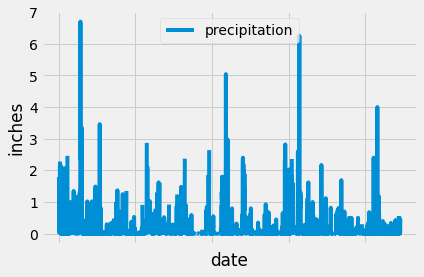

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results starting from the most recent data point in the database. 
#--------------------------------------------------

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns = ["date", "prcp"])
prcp_df.set_index("date", inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(["date"])

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=90)
ax.set_ylabel("inches")
ax.set_xticklabels([])
plt.legend(["precipitation"])

plt.show

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = prcp_df["prcp"].describe()
stats_df = pd.DataFrame(stats)
stats_df.rename(columns = {"prcp": "precipitation"})

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).group_by(Station.station).count()

9

In [12]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).first()
most_active_station = most_active[0]

lowest_temperature_stats = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
lowest_temperature = [item[0] for item in lowest_temperature_stats]

highest_temperature_stats = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
highest_temperature = [item[0] for item in highest_temperature_stats]

avg_temperature_stats = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
avg_temperature = [item[0] for item in avg_temperature_stats]

print(f"The lowest temperature reported from station {most_active_station} is {lowest_temperature}.")
print(f"The highest temperature reported from station {most_active_station} is {highest_temperature}.")
print(f"The average temperature reported from station {most_active_station} is {avg_temperature}.")

The lowest temperature reported from station USC00519281 is [54.0].
The highest temperature reported from station USC00519281 is [85.0].
The average temperature reported from station USC00519281 is [71.66378066378067].


<AxesSubplot:ylabel='Frequency'>

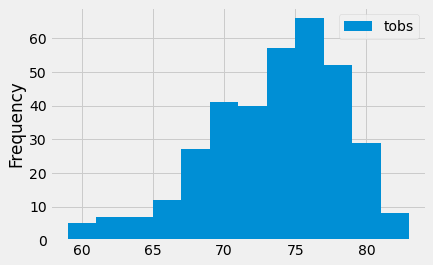

In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date > one_year_date).all()

most_active_df = pd.DataFrame(most_active_data)
most_active_df.plot(kind="hist",bins=12)

# Bonus: Temperature Analysis I

In [15]:
# "tobs" is "temperature observations"
df = pd.read_csv('hawaii_measurements.csv')
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [16]:
# Convert the date column format from string to datetime
df['date']= pd.to_datetime(df['date'])

In [17]:
# Set the date column as the DataFrame index
df.set_index('date', inplace=True)
df.head()

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65
2010-01-02,USC00519397,0.00,63
2010-01-03,USC00519397,0.00,74
2010-01-04,USC00519397,0.00,76
2010-01-06,USC00519397,NaN,73


In [21]:
# Filter data for desired months
june_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '06').all()
december_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '12').all()

# convert raw data to DataFrames to label them and then concatenate into one DataFrame
june_df = pd.DataFrame(june_data,columns=["Date","Temperature"])
december_df = pd.DataFrame(december_data,columns=["Date","Temperature"])
june_df["Month"] = "June"
december_df["Month"] = "December"
avg_temp_df = pd.concat([june_df,december_df], ignore_index=True)

# calculate the average for both June and December
avg_temp_month = avg_temp_df.groupby("Month").mean()
avg_temp_month

,Temperature
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

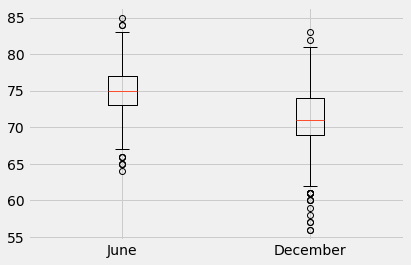

In [22]:
# Run paired t-test
ttest_data = [june_df["Temperature"],december_df["Temperature"]]
plt.boxplot(ttest_data,labels=['June', 'December']);
scipy.stats.ttest_ind(june_df["Temperature"],december_df["Temperature"])

# Close session

In [ ]:
# Close Session
session.close()